In [1]:
import pandas as pd

In [2]:
import pandas as pd

df = pd.read_csv("sapmaintance.csv", encoding="ISO-8859-1", sep=";")
df.columns = df.columns.str.strip()

df["Data zawiadom."] = pd.to_datetime(df["Data zawiadom."], errors="coerce")
df = df[df["Data zawiadom."].notna()]
df = df[df["Data zawiadom."] >= "2020-01-01"]
df = df[df["Opis"].notna() & df["Nr zlec."].notna() & df["Oznaczenie"].notna()]
df["Nr zlec."] = df["Nr zlec."].astype("Int64")
df["Priorytet"] = df["Priorytet"].fillna("Brak")

df["Typ_zawiadomienia"] = df["Rodzaj zawiad."].apply(lambda x: "Awaria" if x == "1P" else "Prewencyjne")

df = df.sort_values(by=["Oznaczenie", "Data zawiadom."]).reset_index(drop=True)

df["Dni_od_ostatniej_awarii"] = df.groupby("Oznaczenie")["Data zawiadom."].diff().dt.days

last_preventive = {}
dzien_od_prewencji = []

for _, row in df.iterrows():
    machine = row["Oznaczenie"]
    current_date = row["Data zawiadom."]
    last = last_preventive.get(machine, pd.NaT)
    if pd.notna(last):
        days = (current_date - last).days
    else:
        days = None
    dzien_od_prewencji.append(days)

    if row["Typ_zawiadomienia"] == "Prewencyjne":
        last_preventive[machine] = current_date

df["Dni_od_ostatniej_prewencji"] = dzien_od_prewencji

df_failures = df[df["Typ_zawiadomienia"] == "Awaria"]
df_failures = df_failures[df_failures["Dni_od_ostatniej_awarii"].notna()]



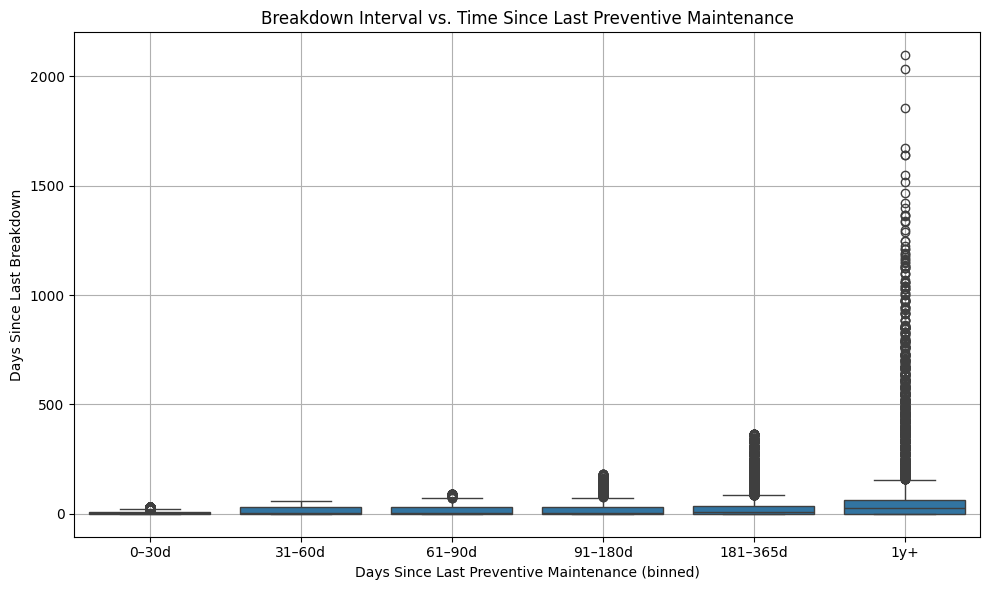

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_failures["bin_prewencja"] = pd.cut(
    df_failures["Dni_od_ostatniej_prewencji"],
    bins=[0, 30, 60, 90, 180, 365, 10000],
    labels=["0–30d", "31–60d", "61–90d", "91–180d", "181–365d", "1y+"]
)

plt.figure(figsize=(10, 6))
sns.boxplot(x="bin_prewencja", y="Dni_od_ostatniej_awarii", data=df_failures)
plt.title("Breakdown Interval vs. Time Since Last Preventive Maintenance")
plt.xlabel("Days Since Last Preventive Maintenance (binned)")
plt.ylabel("Days Since Last Breakdown")
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

df_failures["Data zawiadom."] = pd.to_datetime(df_failures["Data zawiadom."], errors="coerce")

df_failures["Dzien_tygodnia"] = df_failures["Data zawiadom."].dt.day_name()

df_failures["Target_szybko_awaria"] = (df_failures["Dni_od_ostatniej_awarii"] < 30).astype(int)

model_df = df_failures.dropna(subset=["Dni_od_ostatniej_prewencji", "Dzien_tygodnia", "Priorytet", "Oznaczenie"])

X = model_df[["Oznaczenie", "Dzien_tygodnia", "Priorytet", "Dni_od_ostatniej_prewencji"]]
X = pd.get_dummies(X)
y = model_df["Target_szybko_awaria"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.51      0.54      1548
           1       0.80      0.83      0.82      3632

    accuracy                           0.74      5180
   macro avg       0.68      0.67      0.68      5180
weighted avg       0.73      0.74      0.73      5180

Confusion Matrix:
 [[ 791  757]
 [ 602 3030]]


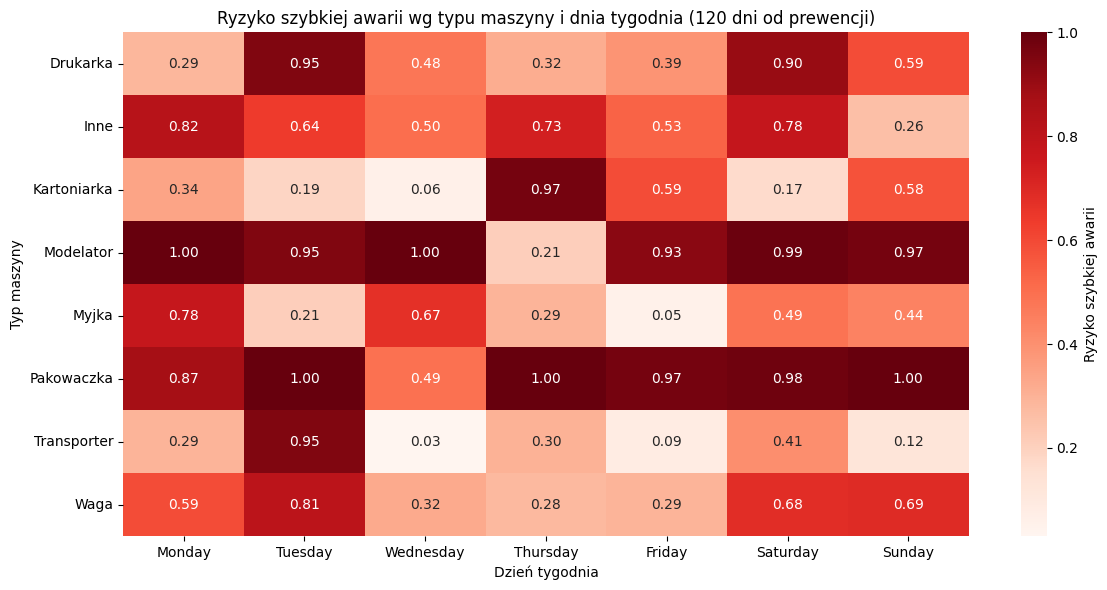

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import itertools

df_failures["Data zawiadom."] = pd.to_datetime(df_failures["Data zawiadom."], errors="coerce")
df_failures["Dzien_tygodnia"] = df_failures["Data zawiadom."].dt.day_name()
df_failures["Target_szybko_awaria"] = (df_failures["Dni_od_ostatniej_awarii"] < 30).astype(int)

df_failures["Typ_maszyny"] = df_failures["Oznaczenie"].str.extract(r"(Pakowaczka|Kartoniarka|Modelator|Zgrzewarka|Myjka|Maszyna pakująca|Transporter|Detektor|Drukarka|Waga)", expand=False)
df_failures["Typ_maszyny"] = df_failures["Typ_maszyny"].fillna("Inne")

model_df = df_failures.dropna(subset=["Dni_od_ostatniej_prewencji", "Dzien_tygodnia", "Priorytet", "Typ_maszyny"])
X = pd.get_dummies(model_df[["Typ_maszyny", "Dzien_tygodnia", "Priorytet", "Dni_od_ostatniej_prewencji"]])
y = model_df["Target_szybko_awaria"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

top_types = model_df["Typ_maszyny"].value_counts().head(8).index.tolist()
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
priority = "Brak"
prevention_days = 120

test_df = pd.DataFrame(itertools.product(top_types, days), columns=["Typ_maszyny", "Dzien_tygodnia"])
test_df["Priorytet"] = priority
test_df["Dni_od_ostatniej_prewencji"] = prevention_days

test_encoded = pd.get_dummies(test_df)
test_encoded = test_encoded.reindex(columns=X.columns, fill_value=0)
test_df["Prawdopodobieństwo_szybkiej_awarii"] = model.predict_proba(test_encoded)[:, 1]

pivot = test_df.pivot(index="Typ_maszyny", columns="Dzien_tygodnia", values="Prawdopodobieństwo_szybkiej_awarii")
pivot = pivot[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Ryzyko szybkiej awarii'})
plt.title(f"Ryzyko szybkiej awarii wg typu maszyny i dnia tygodnia ({prevention_days} dni od prewencji)")
plt.xlabel("Dzień tygodnia")
plt.ylabel("Typ maszyny")
plt.tight_layout()
plt.show()


/tmp/ipykernel_111339/888304339.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_risk = df_plot.groupby("Prevention_Days")["Risk"].mean()


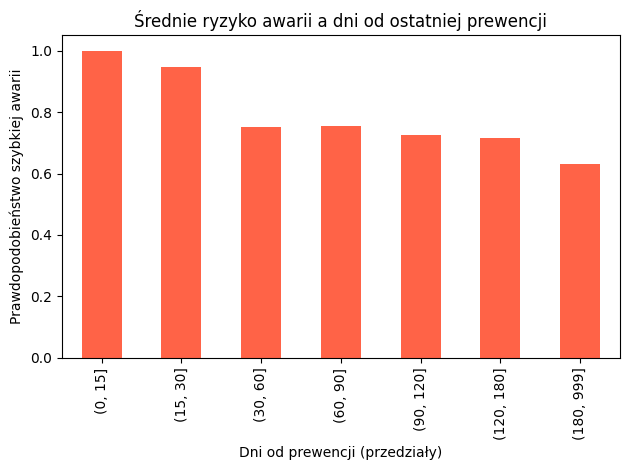

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = df_failures.copy()
df_plot["Risk"] = df_plot["Target_szybko_awaria"]
df_plot["Prevention_Days"] = pd.cut(df_plot["Dni_od_ostatniej_prewencji"], bins=[0, 15, 30, 60, 90, 120, 180, 999])

avg_risk = df_plot.groupby("Prevention_Days")["Risk"].mean()

avg_risk.plot(kind='bar', color='tomato')
plt.title("Średnie ryzyko awarii a dni od ostatniej prewencji")
plt.ylabel("Prawdopodobieństwo szybkiej awarii")
plt.xlabel("Dni od prewencji (przedziały)")
plt.tight_layout()
plt.show()
